# El dataset se puede descargar de: https://www.kaggle.com/datasets/imsparsh/musicnet-dataset

Una vez descargado se debe poner en la carpeta /kaggle/input/musicnet-dataset todo el contenido de la descarga

_______________________________

Para la ejecucipn de este cuaderno se deben instalar las siguientes librerias (en las versiones establecidas), tal como se muestra a continuacion

# importamos las librerias a usar

In [2]:
import numpy as np 
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import IPython.display as ipd

import matplotlib.pyplot as plt
plt.figure(figsize=(15,5))

import librosa
import librosa.display

import os

In [3]:
"""
for dirname, _, filenames in os.walk('/kaggle/input'):
    print(dirname)
    for id, filename in enumerate(filenames):
        print(os.path.join(dirname, filename))
        if id > 10:
            break
            
"""

"\nfor dirname, _, filenames in os.walk('/kaggle/input'):\n    print(dirname)\n    for id, filename in enumerate(filenames):\n        print(os.path.join(dirname, filename))\n        if id > 10:\n            break\n            \n"

In [17]:
class Wav:
    
    path_wav="/kaggle/input/musicnet-dataset/musicnet/musicnet/train_data/"
    
    def __init__(self):
        self.file_wav=os.listdir(self.path_wav)
    
    def cargar(self, i:int, draw=False):
        audio_usar = self.path_wav + self.file_wav[i]
        self.data, self.sampling_rate = librosa.load(audio_usar)
        
        if draw:
            librosa.display.waveplot(self.data, sr=self.sampling_rate)
            plt.title("normal")
            plt.show()
        
        return self.data, self.sampling_rate
    
    def extraer_espectograma(self):
        self.S = librosa.feature.melspectrogram(y=self.data, sr=self.sampling_rate, n_mels=128,fmax=10000)
        return self.S
        
    def convertir_db(self, draw=False):
        #Convert a power spectrogram (amplitude squared) to decibel (dB) units
        self.S_dB = librosa.power_to_db(self.S, ref=np.max)
        
        if draw:
            librosa.display.specshow(self.S_dB, x_axis='time',y_axis='mel', sr=self.sampling_rate,fmax=10000, fmin=200)
            self.__prepare_show("DB")
            plt.show()
            
        return self.S_dB
    
    def __prepare_show(self, title):
        plt.colorbar(format='%+2.0f dB')
        plt.title(title)
        plt.tight_layout()
        



In [18]:
wav = Wav()

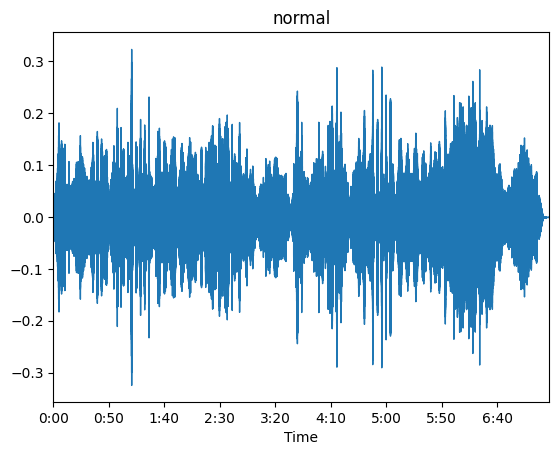

numpy.ndarray

In [19]:
data, _ = wav.cargar(0, True)
type(data)

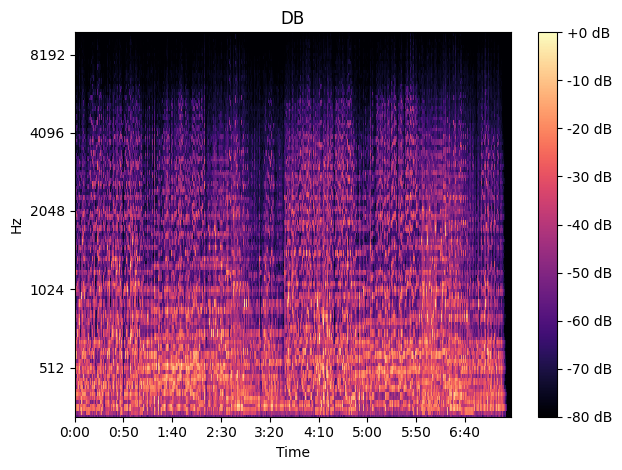

numpy.ndarray

In [20]:
wav.extraer_espectograma()
db= wav.convertir_db(True)
type(db)